In [1]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender imageio==2.4.1 atari-py==0.2.6 gym==0.17.3
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
# !pip install ptan pytorch-ignite pybullet
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 38.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.2/790.2 KB 50.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.2 MB/s eta 0:00:00
Reason for being yanked: re-release with new wheels
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=68541526927c3f7f2bbe58521eb36155375337af4a88557179a51cbca3d7dcd3
  Stored in directory: /root/.cache/pip/wheels/be/7b/04/4d8d56f1d503e5c404f0de6018c0cfa592c71588a39b49e002
  Created wheel for atari-py: filename=atari_py-0.2.6-cp38-cp38-linux_x86_64.whl size=3093100 sha256=17d60

In [2]:
import collections
from typing import Union
import math
import random
from copy import deepcopy
from typing import Optional
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn.utils as nn_utils
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack
from colabgymrender.recorder import Recorder
from fastprogress import progress_bar as pb
import matplotlib.pyplot as plt

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2973696/45929032 bytes (6.5%)4972544/45929032 bytes (10.8%)7684096/45929032 bytes (16.7%)9961472/45929032 bytes (21.7%)12451840/45929032 bytes (27.1%)15130624/45929032 bytes (32.9%)16629760/45929032 bytes (36.2%)20250624/45929032 bytes (44.1%)23674880/45929032 bytes (51.5%)26673152/45929032 bytes (58.1%)29696000/45929032 bytes (64.7%)31481856/45929032 bytes (68.5%)3

In [3]:
class ExpBuffer:

    def __init__(
        self,
        max_size: int = 1024,
        prob_alpha: float = 0.6,
        beta_start: float = 0.4,
        beta_frames: float = 100000,
        n_step: int = 4,
        gamma: float = 0.99,
    ):
        self._prob_alpha = prob_alpha
        self._max_size = max_size
        self._buf = []
        self._pos = 0
        self._beta_start = beta_start
        self._beta = beta_start
        self._beta_frames = beta_frames
        self._n_step = n_step
        self._gamma = gamma
        self._total_discounted_rewards = np.array([np.nan]*max_size)
        self._last_states = [np.nan]*max_size

    def update_bata(self, idx) -> None:
        beta = self._beta_start + idx * (1.0 - self._beta_start) / self._beta_frames
        self._beta = min(1.0, beta)
        return self._beta

    def __len__(self):
        return len(self._buf)

    def append(
        self,
        state: np.ndarray,
        action: int,
        reward: Union[int, float],
        done: bool,
        next_state: np.ndarray,
    ) -> None:
        if len(self._buf) < self._max_size:
            self._buf.append(
                (state, action, reward, done, next_state)
            )
        else:
            self._buf[self._pos] = (state, action, reward, done, next_state)

        if len(self._buf) >= self._n_step:
            dis_r = 0.0
            last_state = self._buf[self._pos][0]
            for i in range(self._n_step):
                state, _, r, done, _ = self._buf[self._pos - i]
                dis_r = r + self._gamma * dis_r
                if done:
                    last_state = state
                    dis_r = r  # ※
                self._total_discounted_rewards[self._pos - i] = dis_r
                self._last_states[self._pos - i] = last_state
            
            for i in range(self._n_step-1):
                done = self._buf[self._pos - i][3]
                if done:
                    break
                self._total_discounted_rewards[self._pos - i] = np.nan
                self._last_states[self._pos - i] = np.nan

        self._pos = (self._pos + 1) % self._max_size

    def get_latest_n(self, n: int):
        if len(self._buf) < self._max_size:
            if len(self._buf) < n+self._n_step:
                raise RuntimeError('get_latest_n : len(self._buf) < n+self._n_step')
            s_idx = self._pos - self._n_step - n 
            e_idx = self._pos - self._n_step
            latest_exps = self._buf[s_idx:e_idx]
            latest_total_rewards = self._total_discounted_rewards[s_idx:e_idx]
            latest_last_states = self._last_states[s_idx:e_idx]
        else:
            s_idx = self._pos + self._max_size - self._n_step - n
            e_idx = self._pos + self._max_size - self._n_step
            latest_exps = (self._buf*2)[s_idx:e_idx]
            latest_total_rewards = np.concatenate([self._total_discounted_rewards]*2)[s_idx:e_idx]
            latest_last_states = (self._last_states*2)[s_idx:e_idx]
        if len(latest_total_rewards) != n:
            print(f'{s_idx} : {e_idx} : {e_idx-s_idx} : {len((self._total_discounted_rewards*2))}')
        assert len(latest_exps) == n
        assert len(latest_total_rewards) == n
        assert len(latest_last_states) == n
        states, actions, rewards, dones, next_states = zip(*latest_exps)
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)
        next_states = np.array(next_states)
        last_states = np.stack(latest_last_states)
        return states, actions, rewards, dones, latest_total_rewards, last_states

    def update_priorities(self, sample_indices: np.ndarray, sample_priorities: np.ndarray) -> None:
        self._priorities[sample_indices] = sample_priorities

    @property
    def gamma(self) -> float:
        return self._gamma

    @property
    def n_step(self) -> float:
        return self._n_step

In [4]:
class NoisyLinear(nn.Linear):

    def __init__(self, in_features, out_features, sigma_init=0.017, bias=True):
        super(NoisyLinear, self).__init__(in_features, out_features, bias=bias)
        w = torch.full((out_features, in_features), sigma_init)
        self._sigma_weight = nn.Parameter(w)
        z = torch.zeros(out_features, in_features)
        self.register_buffer("epsilon_weight", z)
        if bias:
            w = torch.full((out_features,), sigma_init)
            self._sigma_bias = nn.Parameter(w)
            z = torch.zeros(out_features)
            self.register_buffer("epsilon_bias", z)
        self.reset_parameters()

    def reset_parameters(self):
        std = math.sqrt(3 / self.in_features)
        self.weight.data.uniform_(-std, std)
        self.bias.data.uniform_(-std, std)

    def forward(self, input):
        self.epsilon_weight.normal_()
        bias = self.bias
        if bias is not None:
            self.epsilon_bias.normal_()
            bias = bias + self._sigma_bias * \
                   self.epsilon_bias.data
        v = self._sigma_weight * self.epsilon_weight.data + \
            self.weight
        return F.linear(input, v, bias)

In [5]:
class A2C(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(A2C, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.policy = nn.Sequential(
            NoisyLinear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

        self.value = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        # x = x.float() / 256
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.policy(conv_out), self.value(conv_out)

In [6]:
class Agent:

    def __init__(
        self,
        env,
        exp_buffer: ExpBuffer,
        net: nn.Module,
        epsilon_start: float = 1.0,
        epsilon_final: float = 0.01,
        epsilon_decay_last_step: int = 200000,
        tgt_sync_steps: int = 10000,
        learning_rate: float = 1e-4,
        adam_eps: float = None,
        clip_grad: float = 0.1,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
        use_sync_net: bool = False,
    ):
        self._env = env
        self._exp_buffer = exp_buffer
        self._net = net
        self._tgt_net = deepcopy(net)
        for p in self._tgt_net.parameters():
            p.requires_grad = False
        self._epsilon_start = epsilon_start
        self._epsilon_final = epsilon_final
        self._epsilon_decay_last_step = epsilon_decay_last_step
        self._epsilon = epsilon_start
        self._device = device
        self._total_step = 0
        self._total_trained_samples = 0
        self._clip_grad = clip_grad
        self._tgt_sync_steps = tgt_sync_steps
        adam_kwargs = {}
        if adam_eps is not None:
            adam_kwargs['eps'] = adam_eps
        self._optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, **adam_kwargs)
        self._reset_episode()
        self._use_sync_net = use_sync_net
        self._episode = 0

    def _reset_episode(self):
        self._state = self._env.reset()
        self._total_reward = 0.0

    @torch.no_grad()
    def play_step(self, epsilon: Optional[float] = None, sync_target: bool = True):
        if epsilon is None:
            epsilon = self._epsilon
        done_reward = None

        if np.random.random() < epsilon:
            action = self._env.action_space.sample()
        else:
            state_a = np.array([self._state], copy=False)
            state_v = torch.tensor(state_a).to(self._device)
            logits_v, value_v = self._net(state_v)
            # _, act_v = torch.max(logits_v, dim=1)
            # action = int(act_v.item())
            probs_v = F.softmax(logits_v, dim=1)
            prob = probs_v.data.cpu().numpy()[0]
            action = np.random.choice(len(prob), p=prob)

        next_state, reward, is_done, _ = self._env.step(action)
        self._total_reward += reward

        self._exp_buffer.append(
            self._state, action, reward, is_done, next_state
        )
        self._state = next_state
        if is_done:
            done_reward = self._total_reward
            self._reset_episode()

        self._total_step += 1
        self._update_epsilon(self._total_step)
        self._exp_buffer.update_bata(self._total_step)

        if self._total_step % self._tgt_sync_steps == 0 and sync_target and self._use_sync_net:
            self._tgt_net.load_state_dict(self._net.state_dict())
            print(f'synced target net')

        return done_reward

    def train(self, n_iter: int = 1, batch_size: int = 32) -> None:
        n_step_gamma = self._exp_buffer.gamma ** self._exp_buffer.n_step
        for i in range(n_iter):
            for s in range(batch_size):
                done_reward = self.play_step()
                if done_reward is not None:
                    print(f'episode : {self._episode}, done reward : {done_reward}, total_step : {self._total_step}, cur_epsilon : {self._epsilon}')
                    self._episode += 1
            states, actions, rewards, dones, total_discounted_rewards, \
                last_states = self._exp_buffer.get_latest_n(batch_size)
            states_v = torch.tensor(states).to(self._device)
            actions_v = torch.tensor(actions).to(self._device)
            discounted_rewards_v = torch.tensor(total_discounted_rewards).to(self._device)
            done_mask = torch.BoolTensor(dones).to(self._device)
            # weights_v = torch.tensor(weights).to(self._device)

            with torch.no_grad():
                last_states_v = torch.tensor(last_states).to(self._device)
                if self._use_sync_net:
                    last_state_values = self._tgt_net(last_states_v)[1].squeeze(-1)
                else:
                    last_state_values = self._net(last_states_v)[1].squeeze(-1)
                last_state_values[done_mask] = 0.0
                # print(f'[1] {last_state_values.shape} : {discounted_rewards_v.shape}')
                expected_state_values = last_state_values.detach() * n_step_gamma + discounted_rewards_v

            self._optimizer.zero_grad()
            logits_v, value_v = self._net(states_v)
            # print(f'[2] {value_v.shape} : {expected_state_values.shape}')
            loss_value_v = F.mse_loss(value_v.squeeze(-1).float(), expected_state_values.float())  # (Q(s,a) - V(s))^2

            log_prob_v = F.log_softmax(logits_v, dim=1)
            adv_v = expected_state_values - value_v.detach()  # Q(s,a) - V(s)  Q(s,a)=R?
            log_prob_actions_v = adv_v * log_prob_v[range(batch_size), actions_v]
            # log_prob_actions_v *= weights_v
            loss_policy_v = -log_prob_actions_v.mean()

            prob_v = F.softmax(logits_v, dim=1)
            entropy_loss_v = batch_size * (prob_v * log_prob_v).sum(dim=1).mean()

            loss_policy_v.backward(retain_graph=True)
            grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                                    for p in self._net.parameters()
                                    if p.grad is not None])

            loss_v = entropy_loss_v + loss_value_v
            loss_v.backward()
            nn_utils.clip_grad_norm_(self._net.parameters(), self._clip_grad)
            self._optimizer.step()

            loss_v += loss_policy_v

            # self._exp_buffer.update_priorities(sampled_indices, prios)
            self._total_trained_samples += batch_size

    def initial_exploration(self, n_steps: int = 10000, epsilon: float = 1.0) -> None:
        eps_bak = self._epsilon
        for i in pb(range(n_steps)):
            self._epsilon = epsilon
            self.play_step(sync_target=False)
        self._total_step = 0
        self._epsilon = eps_bak

    def _update_epsilon(self, step_index: int) -> None:
        self._epsilon = max(
            self._epsilon_final,
            self._epsilon_start - step_index / self._epsilon_decay_last_step
        )

In [7]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


class LazyFramesToNumpy(gym.ObservationWrapper):
    def __init__(self, env):
        super(LazyFramesToNumpy, self).__init__(env)

    def observation(self, observation):
        return observation.__array__()

In [8]:
SEED = 77

In [41]:
random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

!rm -rf /content/video

env = gym.make("Breakout-v0")
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=224)
env = FrameStack(env, num_stack=4)
env = LazyFramesToNumpy(env)
directory = './video'
env = Recorder(env, directory)

In [42]:
env.observation_space.shape, env.action_space.n

((4, 224, 224), 4)

In [43]:
net = A2C(input_shape=env.observation_space.shape, n_actions=env.action_space.n).to(device)

In [44]:
exp_buffer = ExpBuffer(
    # max_size=10000,
    prob_alpha=0.6,
    beta_start=0.4,
    beta_frames=30000, #100000,
    n_step=20,
    gamma=0.99,
)

In [45]:
agent = Agent(
    env=env,
    exp_buffer=exp_buffer,
    net=net,
    epsilon_start=0.5,
    epsilon_final=0.0,
    epsilon_decay_last_step=30000, #200000,
    tgt_sync_steps=1000,
    learning_rate=1e-4,
    adam_eps=1e-3,
    device=device
)

In [46]:
state = env.reset()

In [47]:
state.shape

(4, 224, 224)

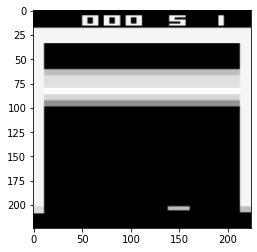

In [48]:
plt.imshow(state[0], cmap='gray')

In [49]:
net(torch.tensor(state).unsqueeze(0).to(device))  # (π(a | s=state), V(state))

(tensor([[-0.0459, -0.0616, -0.0880,  0.0331]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[0.0149]], device='cuda:0', grad_fn=<AddmmBackward0>))

In [50]:
# for n-step
agent.initial_exploration(n_steps=100)

In [51]:
!rm -rf /content/video/*

In [ ]:
episode = 0

while True:
    agent.train(n_iter=20, batch_size=32)

ストリーミング出力は最後の 5000 行に切り捨てられました。
episode : 23888, done reward : 1.0, total_step : 1784777, cur_epsilon : 0.0
episode : 23889, done reward : 1.0, total_step : 1784845, cur_epsilon : 0.0
episode : 23890, done reward : 2.0, total_step : 1784934, cur_epsilon : 0.0
episode : 23891, done reward : 2.0, total_step : 1785022, cur_epsilon : 0.0
episode : 23892, done reward : 0.0, total_step : 1785074, cur_epsilon : 0.0
episode : 23893, done reward : 0.0, total_step : 1785128, cur_epsilon : 0.0
episode : 23894, done reward : 1.0, total_step : 1785196, cur_epsilon : 0.0
episode : 23895, done reward : 3.0, total_step : 1785314, cur_epsilon : 0.0
episode : 23896, done reward : 1.0, total_step : 1785376, cur_epsilon : 0.0
episode : 23897, done reward : 4.0, total_step : 1785492, cur_epsilon : 0.0
episode : 23898, done reward : 1.0, total_step : 1785546, cur_epsilon : 0.0
episode : 23899, done reward : 3.0, total_step : 1785639, cur_epsilon : 0.0
episode : 23900, done reward : 1.0, total_step : 1785705

In [30]:
# exp_buffer = ExpBuffer(
#     # max_size=10000,
#     prob_alpha=0.6,
#     beta_start=0.4,
#     beta_frames=30000, #100000,
#     n_step=8,
#     gamma=0.99,
# )
# agent = Agent(
#     env=env,
#     exp_buffer=exp_buffer,
#     net=net,
#     epsilon_start=0.5,
#     epsilon_final=0.0,
#     epsilon_decay_last_step=30000, #200000,
#     tgt_sync_steps=1000,
#     learning_rate=1e-4,
#     adam_eps=1e-3,
#     device=device
# )

episode = 0

while True:
    agent.train(n_iter=20, batch_size=32)

episode : 0, done reward : 1.0, total_step : 33, cur_epsilon : 0.4989
episode : 1, done reward : 3.0, total_step : 133, cur_epsilon : 0.49556666666666666
episode : 2, done reward : 0.0, total_step : 186, cur_epsilon : 0.4938
episode : 3, done reward : 2.0, total_step : 267, cur_epsilon : 0.4911
episode : 4, done reward : 2.0, total_step : 329, cur_epsilon : 0.4890333333333333
episode : 5, done reward : 0.0, total_step : 384, cur_epsilon : 0.4872
episode : 6, done reward : 2.0, total_step : 463, cur_epsilon : 0.48456666666666665
episode : 7, done reward : 2.0, total_step : 552, cur_epsilon : 0.48160000000000003
episode : 8, done reward : 2.0, total_step : 621, cur_epsilon : 0.4793
episode : 9, done reward : 1.0, total_step : 685, cur_epsilon : 0.4771666666666667
episode : 10, done reward : 2.0, total_step : 781, cur_epsilon : 0.47396666666666665
episode : 11, done reward : 0.0, total_step : 827, cur_epsilon : 0.4724333333333333
episode : 12, done reward : 0.0, total_step : 872, cur_epsi

KeyboardInterrupt: ignored

In [20]:
# exp_buffer = ExpBuffer(
#     # max_size=10000,
#     prob_alpha=0.6,
#     beta_start=0.4,
#     beta_frames=30000, #100000,
#     n_step=4,
#     gamma=0.99,
# )
# agent = Agent(
#     env=env,
#     exp_buffer=exp_buffer,
#     net=net,
#     epsilon_start=0.0,
#     epsilon_final=0.0,
#     epsilon_decay_last_step=30000, #200000,
#     tgt_sync_steps=1000,
#     learning_rate=5e-4,
#     adam_eps=1e-3,
#     device=device
# )

episode = 0

while True:
    agent.train(n_iter=20, batch_size=32)

episode : 0, done reward : 1.0, total_step : 13, cur_epsilon : 0.0
episode : 1, done reward : 0.0, total_step : 57, cur_epsilon : 0.0
episode : 2, done reward : 1.0, total_step : 120, cur_epsilon : 0.0
episode : 3, done reward : 3.0, total_step : 224, cur_epsilon : 0.0
episode : 4, done reward : 2.0, total_step : 319, cur_epsilon : 0.0
episode : 5, done reward : 1.0, total_step : 390, cur_epsilon : 0.0
episode : 6, done reward : 1.0, total_step : 456, cur_epsilon : 0.0
episode : 7, done reward : 1.0, total_step : 529, cur_epsilon : 0.0
episode : 8, done reward : 3.0, total_step : 629, cur_epsilon : 0.0
episode : 9, done reward : 0.0, total_step : 684, cur_epsilon : 0.0
episode : 10, done reward : 2.0, total_step : 772, cur_epsilon : 0.0
episode : 11, done reward : 3.0, total_step : 880, cur_epsilon : 0.0
episode : 12, done reward : 1.0, total_step : 958, cur_epsilon : 0.0
episode : 13, done reward : 1.0, total_step : 1009, cur_epsilon : 0.0
episode : 14, done reward : 2.0, total_step :

KeyboardInterrupt: ignored

In [ ]:
# exp_buffer = ExpBuffer(
#     # max_size=10000,
#     prob_alpha=0.6,
#     beta_start=0.4,
#     beta_frames=30000, #100000,
#     n_step=4,
#     gamma=0.99,
# )
# agent = Agent(
#     env=env,
#     exp_buffer=exp_buffer,
#     net=net,
#     epsilon_start=0.2,
#     epsilon_final=0.005,
#     epsilon_decay_last_step=30000, #200000,
#     tgt_sync_steps=1000,
#     learning_rate=1e-3,
#     adam_eps=1e-3,
#     device=device
# )

episode = 0

while True:
    agent.train(n_iter=20, batch_size=32)

episode : 0, done reward : 2.0, total_step : 38, cur_epsilon : 0.19873333333333335
episode : 1, done reward : 1.0, total_step : 115, cur_epsilon : 0.19616666666666668
episode : 2, done reward : 3.0, total_step : 197, cur_epsilon : 0.19343333333333335
episode : 3, done reward : 1.0, total_step : 259, cur_epsilon : 0.19136666666666668
episode : 4, done reward : 3.0, total_step : 359, cur_epsilon : 0.18803333333333333
episode : 5, done reward : 3.0, total_step : 448, cur_epsilon : 0.18506666666666668
episode : 6, done reward : 1.0, total_step : 510, cur_epsilon : 0.183
episode : 7, done reward : 0.0, total_step : 555, cur_epsilon : 0.18150000000000002
episode : 8, done reward : 5.0, total_step : 664, cur_epsilon : 0.17786666666666667
episode : 9, done reward : 2.0, total_step : 737, cur_epsilon : 0.17543333333333333
episode : 10, done reward : 5.0, total_step : 869, cur_epsilon : 0.17103333333333334
episode : 11, done reward : 2.0, total_step : 968, cur_epsilon : 0.16773333333333335
synce